# __AIRLINE PASSENGER SATISFACTION__

## __Modelling__

In [1]:
#Import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import category_encoders as ce
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix
import joblib

In [2]:
#Import dataset

data = pd.read_csv('satis_clean.csv')
data

,Satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,5,5,5,3,...,2,2,3,3,4,4,4,2,0,0.0
129876,neutral or dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2,3,2,4,...,1,3,2,3,3,1,2,1,174,172.0
129877,neutral or dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,3,0,3,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,neutral or dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,3,2,3,2,...,2,3,3,2,3,2,1,2,193,205.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

There are still missing value in this data, i will impute in pipeline.

### __DATA SPLITTING__

In [4]:
X = data.drop('Satisfaction', axis =1)
y = data['Satisfaction'].apply(lambda x : 0 if x == 'satisfied' else 1)

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 2021)

### __PREPROCESSING SCHEMA__

__Impute:__
- SimpleImputer with median: Arrival delay in minutes

__Encoding:__
- One hot : Gender, Customer Type, Type of Travel
- Ordinal : Class

__Scalling (depends on model)__
- Robust : Age, Departure Delay in Minutes, Arrival Delay in Minutes

## __BENCHMARK MODELLING__

For the modeling stage, I will focus on as much as possible in predicting which passengers will be dissatisfied/neutral after flown with airline. So that in this modeling, I will focus on __recall__.

__Decision Tree Classifier Bench__

In [6]:
#PIPELINE DTC BENCH

impute_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy = 'median'))
])

#categorical
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop = 'first'))
])

ordinal_mapping=[
    {'col': 'Class',
     'mapping': {'Eco': 0, 'Eco Plus': 1, 'Business': 2}}]

ordinal_pipeline = Pipeline([
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping))
])


#2. TRANSFROM
transformer = ColumnTransformer([
    ('impute_pipe', impute_pipeline, ['Arrival Delay in Minutes']),
    ('onehot_pipe', onehot_pipeline, ['Gender', 'Customer Type', 'Type of Travel']),
    ('ordinal_pipe', ordinal_pipeline, ['Class'])
], remainder = 'passthrough')

#3. MODEL INITIALIZING
dtc_bench = DecisionTreeClassifier()


#4. PIPELINE ALL IN
dtc_bench_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', dtc_bench)
])

__KNeighborsClassifier Bench__

In [7]:
#PIPELINE KNN BENCH


#numerical
numerical_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy = 'median'))
])

#categorical
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop = 'first'))
])

ordinal_mapping=[
    {'col': 'Class',
     'mapping': {'Eco': 0, 'Eco Plus': 1, 'Business': 2}}]

ordinal_pipeline = Pipeline([
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping))
])


#2. TRANSFROM
transformer = ColumnTransformer([
    ('impute_pipe', impute_pipeline, ['Arrival Delay in Minutes']),
    ('onehot_pipe', onehot_pipeline, ['Gender', 'Customer Type', 'Type of Travel']),
    ('ordinal_pipe', ordinal_pipeline, ['Class'])    
], remainder = 'passthrough')

#3. MODEL INITIALIZING
knn_bench = KNeighborsClassifier()


#4. PIPELINE ALL IN
knn_bench_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', knn_bench)
])

__Random Forest Bench__

In [8]:
#PIPELINE RF BENCH


#numerical
numerical_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy = 'median'))
])

#categorical
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop = 'first'))
])

ordinal_mapping=[
    {'col': 'Class',
     'mapping': {'Eco': 0, 'Eco Plus': 1, 'Business': 2}}]

ordinal_pipeline = Pipeline([
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping))
])


#2. TRANSFROM
transformer = ColumnTransformer([
    ('impute_pipe', impute_pipeline, ['Arrival Delay in Minutes']),
    ('onehot_pipe', onehot_pipeline, ['Gender', 'Customer Type', 'Type of Travel']),
    ('ordinal_pipe', ordinal_pipeline, ['Class'])    
], remainder = 'passthrough')

#3. MODEL INITIALIZING
rf_bench = RandomForestClassifier()


#4. PIPELINE ALL IN
rf_bench_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', rf_bench)
])

In [9]:
#cross val with recall


skfold = StratifiedKFold(n_splits = 5, random_state = 2021, shuffle=True) 

knn_cv = cross_val_score(knn_bench_pipeline, X_train_val, y_train_val, cv = skfold, scoring='recall')
dtc_cv = cross_val_score(dtc_bench_pipeline, X_train_val, y_train_val, cv = skfold, scoring='recall')
rf_cv = cross_val_score(rf_bench_pipeline, X_train_val, y_train_val, cv = skfold, scoring='recall')

In [10]:
#cross val score

print('CV KNN', knn_cv) 
print('CV DecisionTree', dtc_cv) 
print('CV Random Forest', rf_cv)

CV KNN [0.8579781  0.85702137 0.860742   0.85553311 0.85392303]
CV DecisionTree [0.92601254 0.9277134  0.93281599 0.93334751 0.93046991]
CV Random Forest [0.95769108 0.95567131 0.95917933 0.96077389 0.96119498]


In [11]:
#mean cross val score every algorithm

print('Mean CV KNN', knn_cv.mean())
print('Mean CV DecisionTree', dtc_cv.mean())
print('Mean CV RandomForest', rf_cv.mean())

Mean CV KNN 0.8570395221224164
Mean CV DecisionTree 0.9300718713705288
Mean CV RandomForest 0.9589021195914091


As we see, the highest cross val score is Random Forest Classifier.

## __MODELLING WITH IMPROVEMENT__

### __PIPELINE__

> __Decision Tree Classifier__

In [12]:
#PIPELINE DTC

impute_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy = 'median')),
    ('pca', PCA (n_components = 1))
])

#categorical
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop = 'first'))
])

ordinal_mapping=[
    {'col': 'Class',
     'mapping': {'Eco': 0, 'Eco Plus': 1, 'Business': 2}}]

ordinal_pipeline = Pipeline([
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping))
])


#2. TRANSFROM
transformer = ColumnTransformer([
    ('impute_pipe', impute_pipeline, ['Arrival Delay in Minutes', 'Departure Delay in Minutes']),
    ('onehot_pipe', onehot_pipeline, ['Gender', 'Customer Type', 'Type of Travel']),
    ('ordinal_pipe', ordinal_pipeline, ['Class'])
], remainder = 'passthrough')

#3. MODEL INITIALIZING
dtc = DecisionTreeClassifier(max_depth = 5, random_state = 2021)
rfe = RFE(estimator = dtc) 


#4. PIPELINE ALL IN
dtc_improve_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', rfe),
    ('clf', dtc)
])

> __KNeighborsClassifier__

In [13]:
#PIPELINE KNN


#numerical
numerical_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy = 'median')),
    ('scal', RobustScaler()),
    ('pca', PCA (n_components = 2))
])

#categorical
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop = 'first'))
])

ordinal_mapping=[
    {'col': 'Class',
     'mapping': {'Eco': 0, 'Eco Plus': 1, 'Business': 2}}]

ordinal_pipeline = Pipeline([
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping))
])


#2. TRANSFROM
transformer = ColumnTransformer([
    ('num_pipe', numerical_pipeline, ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']), 
    ('onehot_pipe', onehot_pipeline, ['Gender', 'Customer Type', 'Type of Travel']),
    ('ordinal_pipe', ordinal_pipeline, ['Class'])    
], remainder = 'passthrough')

#3. MODEL INITIALIZING
knn = KNeighborsClassifier(n_neighbors = 3)


#4. PIPELINE ALL IN
knn_improve_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', knn)
])

> __Random Forest Classifier__

In [14]:
#PIPELINE RF


#numerical
numerical_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy = 'median')),
    ('pca', PCA (n_components = 1))
])

#categorical
onehot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop = 'first'))
])

ordinal_mapping=[
    {'col': 'Class',
     'mapping': {'Eco': 0, 'Eco Plus': 1, 'Business': 2}}]

ordinal_pipeline = Pipeline([
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping))
])


#2. TRANSFROM
transformer = ColumnTransformer([
    ('num_pipe', numerical_pipeline, ['Departure Delay in Minutes', 'Arrival Delay in Minutes']), 
    ('onehot_pipe', onehot_pipeline, ['Gender', 'Customer Type', 'Type of Travel']),
    ('ordinal_pipe', ordinal_pipeline, ['Class'])    
], remainder = 'passthrough')

#3. MODEL INITIALIZING
rf = RandomForestClassifier(n_estimators=20, max_features = 4, max_depth=3, random_state = 2021)
rfe = RFE(estimator = rf)

#4. PIPELINE ALL IN
rf_improve_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', rfe),
    ('clf', rf)
])

### __RESULT__

> __DTC__

In [15]:
#model dtc:

dtc_improve = dtc_improve_pipeline.fit(X_train_val, y_train_val)
y_pred_dtc_improve = dtc_improve.predict(X_test)

print(classification_report(y_test, y_pred_dtc_improve))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     14217
           1       0.85      0.88      0.86     11759

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.88      0.87      0.87     25976



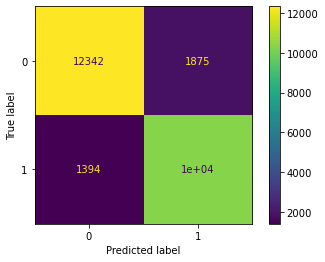

In [16]:
plot_confusion_matrix(dtc_improve, X_test, y_test)
plt.show()

> __KNN__

In [18]:
#model knn:

knn_improve = knn_improve_pipeline.fit(X_train_val, y_train_val)
y_pred_knn_improve = knn_improve.predict(X_test)

print(classification_report(y_test, y_pred_knn_improve))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     14217
           1       0.91      0.92      0.91     11759

    accuracy                           0.92     25976
   macro avg       0.92      0.92      0.92     25976
weighted avg       0.92      0.92      0.92     25976



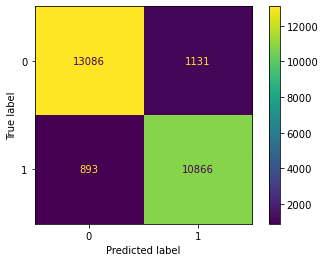

In [19]:
plot_confusion_matrix(knn_improve, X_test, y_test)
plt.show()

> __RF__

In [21]:
#model knn:

rf_improve = rf_improve_pipeline.fit(X_train_val, y_train_val)
y_pred_rf_improve = rf_improve.predict(X_test)

print(classification_report(y_test, y_pred_rf_improve))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14217
           1       0.84      0.84      0.84     11759

    accuracy                           0.85     25976
   macro avg       0.85      0.85      0.85     25976
weighted avg       0.85      0.85      0.85     25976



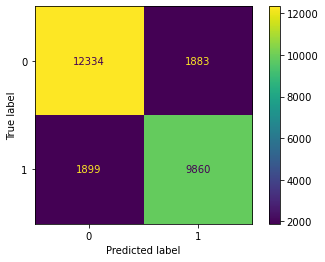

In [22]:
plot_confusion_matrix(rf_improve, X_test, y_test)
plt.show()

After fitting 3 models above, we can see the highest recall score is knn with 0.92 and it has smallest fn than others models.
<br> Lets do hyperparameter tuning all models.

## __HYPERPARAMETER TUNING__

### __Decision Tree Classifier__

In [25]:
dtc_improve_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('impute_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer(strategy='median')),
                                                    ('pca', PCA(n_components=1))]),
                                    ['Arrival Delay in Minutes',
                                     'Departure Delay in Minutes']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Gender', 'Customer Type', 'Type of Travel']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('ordinal',
                                                     OrdinalEncoder(mapping=[{'col': 'C

In [26]:
#hyperparameter tuning dtc with randomized search

#Make hyperparam space
hyperparam_space = {
    'clf__min_samples_split': [4,5,6,7,8,9,10], 
    'clf__max_depth':[2,3,4,5,6,7], 
    'clf__criterion':['entropy', 'gini'] 
}

randomized_search_dtc = RandomizedSearchCV(dtc_improve_pipeline,
    hyperparam_space,
    n_iter = 20,
    cv = 5,
    scoring = 'recall',
    random_state = 2021,
    n_jobs=-1,
    verbose=1
)


randomized_search_dtc.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('impute_pipe',
                                                                               Pipeline(steps=[('impute_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('pca',
                                                                                                PCA(n_components=1))]),
                                                                               ['Arrival '
                                                                                'Delay '
                                                                                'in '
 

In [27]:
# get best score from randomized search result

print('best score', randomized_search_dtc.best_score_)
print('best params', randomized_search_dtc.best_params_)

best score 0.9263725030837261
best params {'clf__min_samples_split': 9, 'clf__max_depth': 7, 'clf__criterion': 'entropy'}


In [28]:
#get best param from best estimator

randomized_search_dtc.best_estimator_.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('impute_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer(strategy='median')),
                                                    ('pca', PCA(n_components=1))]),
                                    ['Arrival Delay in Minutes',
                                     'Departure Delay in Minutes']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Gender', 'Customer Type', 'Type of Travel']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('ordinal',
                                                     OrdinalEncoder(mapping=[{'col': 'C

In [29]:
#model fitting with best estimator

dtc_tuned = randomized_search_dtc.best_estimator_.fit(X_train_val, y_train_val)
y_pred_dtctuned = dtc_tuned.predict(X_test)

print(classification_report(y_test, y_pred_dtctuned))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     14217
           1       0.89      0.93      0.91     11759

    accuracy                           0.91     25976
   macro avg       0.91      0.92      0.91     25976
weighted avg       0.92      0.91      0.92     25976



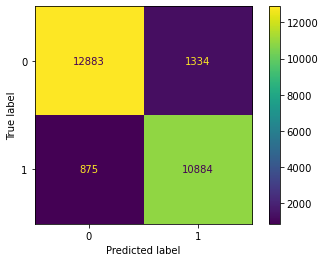

In [31]:
plot_confusion_matrix(dtc_tuned, X_test, y_test)
plt.show()

### __KNeighbors Classifier__

In [32]:
knn_improve_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer(strategy='median')),
                                                    ('scal', RobustScaler()),
                                                    ('pca', PCA(n_components=2))]),
                                    ['Age', 'Departure Delay in Minutes',
                                     'Arrival Delay in Minutes']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Gender', 'Customer Type', 'Type of Travel']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('ordinal',
     

In [33]:
#hyperparameter tuning knn with randomized search

#make hyperparameter space list
hyperparam_space = {
    'clf__n_neighbors': (1,10, 1), 
    'clf__leaf_size': (20,40,1)
}


randomized_search_knn = RandomizedSearchCV(knn_improve_pipeline,
    hyperparam_space,
    n_iter = 20,
    cv = 5,
    scoring = 'recall',
    random_state = 2021,
    n_jobs=-1,
    verbose=1
)


randomized_search_knn.fit(X_train_val, y_train_val)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 11.2min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_pipe',
                                                                               Pipeline(steps=[('impute_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scal',
                                                                                                RobustScaler()),
                                                                                               ('pca',
                                                                                                PCA(n_components=2))]),
                                                     

In [34]:
#Get best param from best estimator

randomized_search_knn.best_estimator_.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer(strategy='median')),
                                                    ('scal', RobustScaler()),
                                                    ('pca', PCA(n_components=2))]),
                                    ['Age', 'Departure Delay in Minutes',
                                     'Arrival Delay in Minutes']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Gender', 'Customer Type', 'Type of Travel']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('ordinal',
     

In [35]:
#Get best param

randomized_search_knn.best_params_

{'clf__n_neighbors': 10, 'clf__leaf_size': 1}

In [36]:
#model fitting knn with best estimator:

knn_tuned = randomized_search_knn.best_estimator_.fit(X_train_val, y_train_val)
y_pred_knntuned = knn_tuned.predict(X_test)

print(classification_report(y_test, y_pred_knntuned))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     14217
           1       0.91      0.92      0.92     11759

    accuracy                           0.92     25976
   macro avg       0.92      0.92      0.92     25976
weighted avg       0.92      0.92      0.92     25976



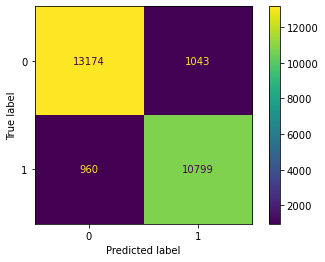

In [37]:
plot_confusion_matrix(knn_tuned, X_test, y_test)
plt.show()

###  __Random Forest Classifier__

In [38]:
rf_improve_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer(strategy='median')),
                                                    ('pca', PCA(n_components=1))]),
                                    ['Departure Delay in Minutes',
                                     'Arrival Delay in Minutes']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Gender', 'Customer Type', 'Type of Travel']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('ordinal',
                                                     OrdinalEncoder(mapping=[{'col': 'Clas

In [39]:
#hyperparameter tuning rf with randomized search

#hyperparameter space list
hyperparam_space = {
    'clf__min_samples_split': [4,5,6,7,8,9,10], 
    'clf__max_depth':[2,3,4,5,6,7]
}


randomized_search_rf = RandomizedSearchCV(rf_improve_pipeline,
    hyperparam_space,
    n_iter = 20,
    cv = 5,
    scoring = 'recall',
    random_state = 2021,
    n_jobs=-1,
    verbose=1
)

randomized_search_rf.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_pipe',
                                                                               Pipeline(steps=[('impute_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('pca',
                                                                                                PCA(n_components=1))]),
                                                                               ['Departure '
                                                                                'Delay '
                                                                                'in '
  

In [40]:
#Get best param from best estimator

randomized_search_rf.best_estimator_.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer(strategy='median')),
                                                    ('pca', PCA(n_components=1))]),
                                    ['Departure Delay in Minutes',
                                     'Arrival Delay in Minutes']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Gender', 'Customer Type', 'Type of Travel']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('ordinal',
                                                     OrdinalEncoder(mapping=[{'col': 'Clas

In [41]:
#Get best param

randomized_search_rf.best_params_

{'clf__min_samples_split': 9, 'clf__max_depth': 7}

In [42]:
#model rf tuned:

rf_tuned = randomized_search_rf.best_estimator_.fit(X_train_val, y_train_val)
y_pred_rftuned = rf_tuned.predict(X_test)

print(classification_report(y_test, y_pred_rftuned))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     14217
           1       0.90      0.87      0.89     11759

    accuracy                           0.90     25976
   macro avg       0.90      0.90      0.90     25976
weighted avg       0.90      0.90      0.90     25976



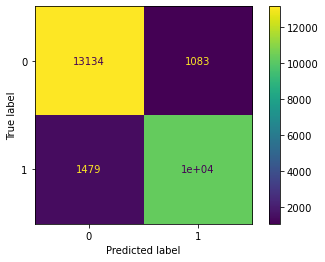

In [43]:
plot_confusion_matrix(rf_tuned, X_test, y_test)
plt.show()

__Make comparison recall before and after hyperparameter tuning__

In [44]:
#Before
dtc_improve_recall = recall_score(y_test, y_pred_dtc_improve)
knn_improve_recall = recall_score(y_test, y_pred_knn_improve)
rf_improve_recall = recall_score(y_test, y_pred_rf_improve)


#After
dtc_tuned_recall = recall_score(y_test, y_pred_dtctuned)
knn_tuned_recall = recall_score(y_test, y_pred_knntuned)
rf_tuned_recall = recall_score(y_test, y_pred_rftuned)

In [61]:
score = {'Classifiers': ['Decision Tree Classifier', 'K-Nearest Neighboor', 'Random Forest Classifier'],  
     'Recall Before Tuned':[dtc_improve_recall, knn_improve_recall, rf_improve_recall],
     'Recall After Tuned':[dtc_tuned_recall, knn_tuned_recall, rf_tuned_recall]}
comparison = pd.DataFrame(data = score)
comparison

,Classifiers,Recall Before Tuned,Recall After Tuned
0,Decision Tree Classifier,0.881453,0.925589
1,K-Nearest Neighboor,0.924058,0.918360
2,Random Forest Classifier,0.838507,0.874224


After do hyperparameter tuning, we get the highest score before tuning getting decrease.
<br> And others model getting increase, now the highest score is decision tree tuned.
<br> So, i declare it as my best model and i will save.

In [46]:
#fit with X, y before save model

dtc_tuned.fit(X, y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pca',
                                                                   PCA(n_components=1))]),
                                                  ['Arrival Delay in Minutes',
                                                   'Departure Delay in '
                                                   'Minutes']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                      

__SAVE MODEL__

In [47]:
#save joblib


joblib.dump(dtc_tuned, 'dtc_tuned')

['dtc_tuned']

In [48]:
#try to load

model_joblib = joblib.load('dtc_tuned')
model_joblib

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pca',
                                                                   PCA(n_components=1))]),
                                                  ['Arrival Delay in Minutes',
                                                   'Departure Delay in '
                                                   'Minutes']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                      

__Test for predict__

In [51]:
features = list(X_train_val.columns)
data = X_train_val.iloc[0].values

In [53]:
dict(zip(features, data))

{'Gender': 'Female',
 'Customer Type': 'disloyal Customer',
 'Age': 34,
 'Type of Travel': 'Business travel',
 'Class': 'Eco',
 'Seat comfort': 3,
 'Departure/Arrival time convenient': 3,
 'Food and drink': 3,
 'Gate location': 3,
 'Inflight wifi service': 3,
 'Inflight entertainment': 3,
 'Online support': 1,
 'Ease of Online booking': 3,
 'On-board service': 2,
 'Leg room service': 2,
 'Baggage handling': 3,
 'Checkin service': 2,
 'Cleanliness': 4,
 'Online boarding': 3,
 'Departure Delay in Minutes': 0,
 'Arrival Delay in Minutes': 0.0}

In [54]:
df_to_predict = pd.DataFrame(dict(zip(features, data)), index = [0])
df_to_predict

,Gender,Customer Type,Age,Type of Travel,Class,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,Female,disloyal Customer,34,Business travel,Eco,3,3,3,3,3,...,1,3,2,2,3,2,4,3,0,0.0


In [55]:
model_joblib.predict(df_to_predict)

array([1], dtype=int64)